#Using Recurrent Neural Networks trying to predict Bitcoin prices

![RNN](https://miro.medium.com/max/2000/1*QFOzE0TEMFERg3G5_5HiPA.png)

While the purpose of this article is not to go in details about how Recurrent Neural Networks (RNN) actually work, we are going to implement the Long Short-Term Memory (LSTM) architecture trying to predict the prices of the Bitcoin for a given Dataset, looking forward to fulfill the steps of exploratory data analysis, data prepossessing, data re scaling, time windowing, model designing, model training and lastly the prediction.

**The goal is to use the past 24 hours of BTC data to predict the value of BTC at the close of the following hour. Lets do it!**



## Exploratory Data Analysis

### Setup

In [1]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

### Importing Data

We are going to import Dataset of the prices of Bitcoin from Coinbase cryptocurrency exchange platform that contains the data of the prices prices formed minute by minute between 2014-12-01 and 2019-01-09:

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://github.com/gcifuentess/holbertonschool-machine_learning/raw/main/supervised_learning/0x0E-time_series/data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip',
    fname='coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

52617216/52602556 [==============================] - 1s 0us/step


In [5]:
df = pd.read_csv(csv_path)

Lets see the very first lines of the dataset:

In [6]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From this first lines, we can conclude at least 3 different things: 1) the data in the first column (Timestamp) of the dataframe is not human readable (at least no for me :D), 2) we found other 7 features and we don't know which to pick, and 3) there are several NaN values in between.

1) Timestamp (not human readable dates), here we can see the equivalency between Timestamp and Datetime:

In [7]:
df_timestamp = df['Timestamp'][:5].to_frame()
df_timestamp['Datetime'] = pd.to_datetime(df_timestamp["Timestamp"], unit='s')
df_timestamp

,Timestamp,Datetime
0,1417411980,2014-12-01 05:33:00
1,1417412040,2014-12-01 05:34:00
2,1417412100,2014-12-01 05:35:00
3,1417412160,2014-12-01 05:36:00
4,1417412220,2014-12-01 05:37:00


Now we can see that the date has a minute periods of time, and we need to transform this to an hourly basis.

2) Watching the relationship between features. For this, we are using a correlogram:

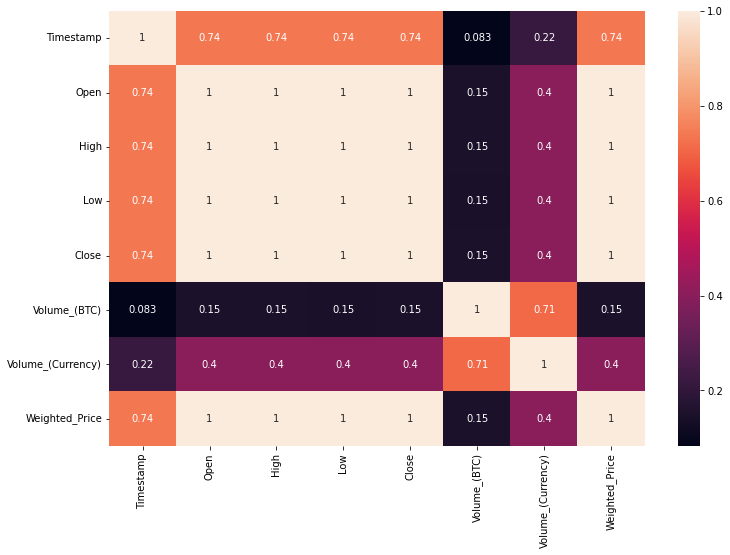

In [8]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

we can see know that Open, High, Low, Close and Weighted_Price features are fully correlated, so for the purpose of this implementation is enough to take just one of them. We decided to pick the Close, because the [Closing Price](https://www.investopedia.com/terms/c/closingprice.asp#:~:text=The%20closing%20price%20is%20the,officially%20closes%20for%20normal%20trading.) is widely used in financial markets.

That lives us with Volume_(BTC) and Volume_(currency) features, but as we are just going to build a simple RNN model, we are going to discard it for the moment. (it will be interesting for a next opportunity to include this features in the model)

3) there are several NaN values in between. Let's count how many NaN values are the Close column:



In [9]:
len(df['Close'][df['Close'].isna()])

109069

In [10]:
print("{:.2%} of the datapoints are NaN values".format(len(df['Close'][df['Close'].isna()]) / len(df['Close'])))

5.19% of the datapoints are NaN values


### Plotting Data
We are going to plot the data for the selected features to keep understanding it:

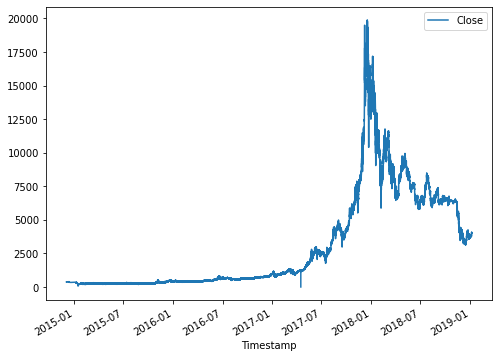

In [11]:
plot_cols = ['Close']
plot_features = df[plot_cols]
plot_features.index = pd.to_datetime(df["Timestamp"], unit='s')
_ = plot_features.plot(subplots=True)

From the above chart we can quickly observe the prices behave reallly different before and after 2017. From 2015 to 2017 the price shows a short range in price volatility and between 2017 and 2019 we observe big movements in it.

We now know we need to transform the time visualization (Datetime), we can just keep the Close feature of the remainder features, we need to handle almost 5% of missing values and the data has almost two types of behavior during time, so let's pre-process the data.

## Data Preprocessing

### Timestamp to Datetime

In [12]:
df['Timestamp'] = pd.to_datetime(df["Timestamp"], unit='s')
df.rename(columns={'Timestamp': 'Datetime'}, inplace=True)
df.head()

,Datetime,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 05:34:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-01 05:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-01 05:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-01 05:37:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Selecting Features

In [13]:
 df = df[['Datetime', 'Close']]
 df.set_index('Datetime', inplace=True)
 df.head()

,Close
Datetime,
2014-12-01 05:33:00,300.0
2014-12-01 05:34:00,NaN
2014-12-01 05:35:00,NaN
2014-12-01 05:36:00,NaN
2014-12-01 05:37:00,NaN


### Handling Missing Values

In [14]:
# We are using Forward fill:
df['Close'].fillna(method='ffill', inplace=True)
df.head()

,Close
Datetime,
2014-12-01 05:33:00,300.0
2014-12-01 05:34:00,300.0
2014-12-01 05:35:00,300.0
2014-12-01 05:36:00,300.0
2014-12-01 05:37:00,300.0


### Changing Periodicity (minutes to hours)

In [15]:
df['Datetime'] = df.index
df = df.groupby([(df.index.year), (df.index.month),(df.index.day), (df.index.hour)]).last()
df.set_index('Datetime', inplace=True)
df.head()

,Close
Datetime,
2014-12-01 05:59:00,300.0
2014-12-01 06:59:00,370.0
2014-12-01 07:59:00,370.0
2014-12-01 08:59:00,370.0
2014-12-01 09:59:00,370.0


If we now look at the tail of the dataframe we can see the last datapoint has not the same periodicity of the rest, so we need to delete it:

In [16]:
df = df[:-1]

### Extract Relevant Section of Data (2017 - 2019)

In [17]:
trunc = df.index.to_series().between("2017", "2021")
df = df[trunc]
df.head()

,Close
Datetime,
2017-01-01 00:59:00,970.27
2017-01-01 01:59:00,970.49
2017-01-01 02:59:00,967.95
2017-01-01 03:59:00,968.14
2017-01-01 04:59:00,968.10


### Slipt Data (Train and Test sets)

In [18]:
SPLIT = 0.70
n = len(df)
train_df = df[0:int(n * SPLIT)]
test_df = df[int(n * SPLIT):]
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
train_df_datetime = train_df.pop('Datetime')
test_df_datetime = test_df.pop('Datetime')

In [19]:
train_df_datetime[0]

Timestamp('2017-01-01 00:59:00')

### Saving Preprocessed Data


In [20]:
train_df.to_csv("./train_df.csv")
test_df.to_csv("./test_df.csv")
train_df_datetime.to_csv("./train_df_datetime.csv")
test_df_datetime.to_csv("./test_df_datetime.csv")

### Plotting The New Preprocessed Data Sets

[]

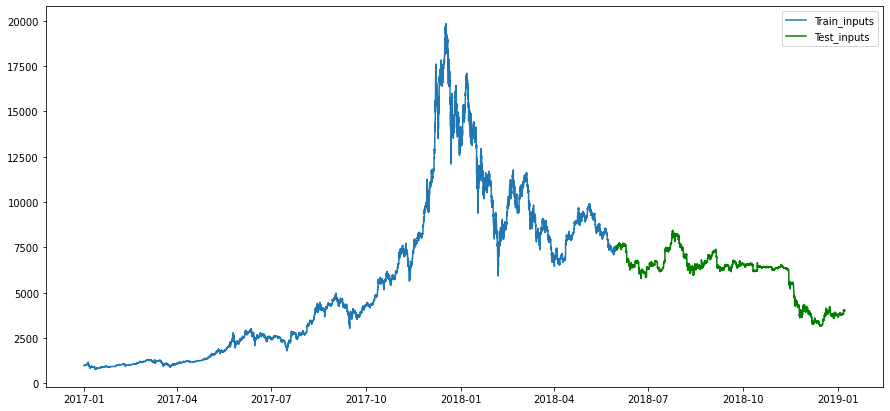

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(train_df_datetime, train_df,
             label='Train_inputs')
plt.plot(test_df_datetime , test_df,
             label='Test_inputs', color='green')
plt.legend()
plt.plot()

## Data Rescaling
To reach a Neural Network convergetion, the data should be rescaled or normalized:

In [22]:
# To read the csv files generated during the Preprocessing
train_df = pd.read_csv("./train_df.csv", index_col=0)
test_df = pd.read_csv("./test_df.csv", index_col=0)
train_df_datetime = pd.read_csv("./train_df_datetime.csv", index_col=0)
test_df_datetime = pd.read_csv("./test_df_datetime.csv", index_col=0)
train_df_datetime['Datetime'] = pd.to_datetime(train_df_datetime['Datetime'])
test_df_datetime['Datetime'] = pd.to_datetime(test_df_datetime['Datetime'])
train_df_datetime.set_index('Datetime', inplace=True)
test_df_datetime.set_index('Datetime', inplace=True)

In [23]:
def rescale_data(df, m_std):
  '''Rescales or normalizes the dataframe with respect to the training mean
     and standard deviation
  Args:
      df is the pandas dataframe to be rescaled
      m_std is a tupple containing the training mean and standard deviation

  Returns: the rescaled data frame
  '''
  return (df - m_std[0]) / m_std[1]

In [24]:
def direscale_data(df, m_std):
  '''Reverses the reescaling or normalization of the dataframe
  Args:
      df is the pandas dataframe to be direscaled
      m_std is a tupple containing the training mean and standard deviation

  Returns: the direscaled data frame
  '''
  return (df * m_std[1]) + m_std[0]

In [25]:
m_std = (train_df.mean(), train_df.std())

In [26]:
train_df = rescale_data(train_df, m_std)
test_df = rescale_data(test_df, m_std)

## Modeling
**IMPORTANT**: All the code in this section (Modeling) is heavily based on the Tensorflow Time Series Tutorial ([check it here](https://www.tensorflow.org/tutorials/structured_data/time_series)). All the credits for them.


### Time windowing
The model in this article will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

* The width (number of time steps) of the input and label windows.
* The time offset between them.
* Which features are used as inputs, labels, or both.

For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:
![Time_Window](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

In [27]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [29]:
def plot(self, model=None, plot_col='Close', max_subplots=4):
  inputs, labels = self.example
  plt.figure(figsize=(12, 16))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n + 1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      p_shape = predictions.shape
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
 
    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [30]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

One important thing to remark here, is the functionality of the tf.data.Dataset() configuration, or in this case the tf.keras.preprocessing.timeseries_dataset_from_array().


I recommend you to check the Tensorflow Guide about [Datasets](https://www.tensorflow.org/guide/data#basic_mechanics), but in short words, what this does is to create an iterable object containing all the input dataset cropped in chunks of size equal to the batch_size, each one containing groups with length sequence_length of datapoints.


For this example (this article) this method will return several chucks of data with shape (64, 25, 1), that later are mapped to be 2 sub groups, one with shape (64, 24, 1) and the other (64, 1, 1), this means chunks with shape [batch, time, features]

In [31]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example

### Model Design (Recurrent Neural Network)

In [32]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    #tf.keras.layers.Reshape([1, -1])
])

Since all of the LSTM layers have set 

```
return_sequences=True
```
the layer returns an output for each input. This is useful for:
* Stacking RNN layers.
* Training a model on multiple time steps simultaneously.

As you can see, we have two stacked LSTM layers, and when the model is trained you will see a Plot of batch samples, where there is outputs for each input.

![LSTM_Windows](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)


### Model Training

Here is defined the function to compile and train the model:

In [33]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping])
  return history                     

Now a WindowGenerator instance is created:

In [34]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Close']

Time to train de model!!

In [35]:
if (not os.path.exists('./bitcoin_prediction.h5')):
    history = compile_and_fit(lstm_model, wide_window)
    lstm_model.save('./bitcoin_prediction.h5')
else:
    lstm_model = tf.keras.models.load_model('./bitcoin_prediction.h5')

Epoch 1/50
194/194 [==============================] - 13s 47ms/step - loss: 0.1048 - mean_absolute_error: 0.1677 - val_loss: 0.0042 - val_mean_absolute_error: 0.0341
Epoch 2/50
194/194 [==============================] - 8s 41ms/step - loss: 0.0220 - mean_absolute_error: 0.0610 - val_loss: 0.0017 - val_mean_absolute_error: 0.0212
Epoch 3/50
194/194 [==============================] - 8s 43ms/step - loss: 0.0062 - mean_absolute_error: 0.0342 - val_loss: 7.2873e-04 - val_mean_absolute_error: 0.0140
Epoch 4/50
194/194 [==============================] - 8s 42ms/step - loss: 0.0021 - mean_absolute_error: 0.0221 - val_loss: 5.7062e-04 - val_mean_absolute_error: 0.0116
Epoch 5/50
194/194 [==============================] - 8s 43ms/step - loss: 0.0011 - mean_absolute_error: 0.0175 - val_loss: 3.8034e-04 - val_mean_absolute_error: 0.0094
Epoch 6/50
194/194 [==============================] - 8s 42ms/step - loss: 7.7737e-04 - mean_absolute_error: 0.0149 - val_loss: 2.6536e-04 - val_mean_absolute_err

### Plotting Training Results

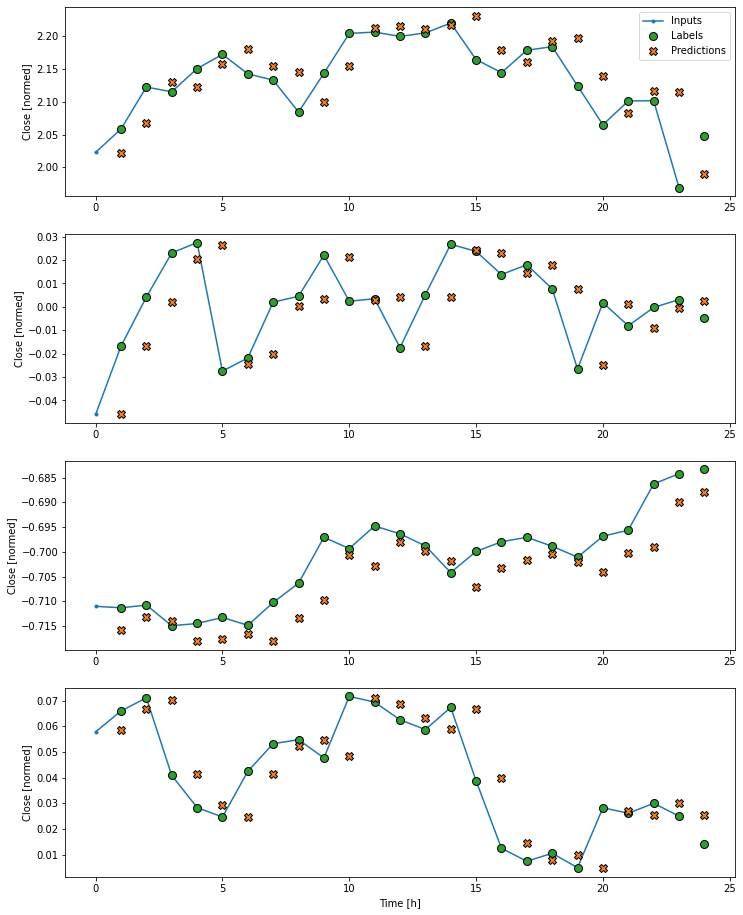

In [36]:
wide_window.plot(lstm_model)

In the above image we can find 4 different examples of 4 different batches of 24 inputs, 24 outputs and 24 labels. As we discuss earlier, this 24 outputs and labels are here because we set return_sequences=True when we were designing the model.

As you can see, even when the predictions are not equal to the labels, they are close enough to move to the prediction of all our test dataset.

## Predicting

### Running Predictions

In [37]:
predictions = lstm_model.predict(
    tf.keras.preprocessing.timeseries_dataset_from_array(
      data= test_df,
      targets=None,
      sequence_length=wide_window.input_width,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)
)

In [38]:
outputs = predictions[:, -1:,:]
new_shape = (outputs.shape[0], outputs.shape[1])

In [39]:
df_preds2_test = pd.DataFrame(
    data=outputs.reshape(new_shape),
    columns=['Close'],
)  

In [40]:
df_preds_test = pd.DataFrame(np.nan, index=range(24), columns=['Close'])
df_preds_test = df_preds_test.append(df_preds2_test)
idx_start = test_df.index[0]
idx_end = test_df.index[-1]
df_preds_test['idxs'] = range(idx_start, idx_end + 2)
df_preds_test.set_index(keys='idxs', drop=True, inplace=True)

In this sub section, we passed to the model all the Test dataset to predict the next value every 24 hours. For that matter and in order to enable or facilitate the plotting of this results, we did this steps:

* Pass the dataset to the model
* Create a dataframe with the outputs
* Insert 24 NaN values at the beginning of the time serie

### Plotting Predictions

In [41]:
# Return the data to is original scale
test_df = direscale_data(test_df, m_std)
df_preds_test = direscale_data(df_preds_test, m_std)

[]

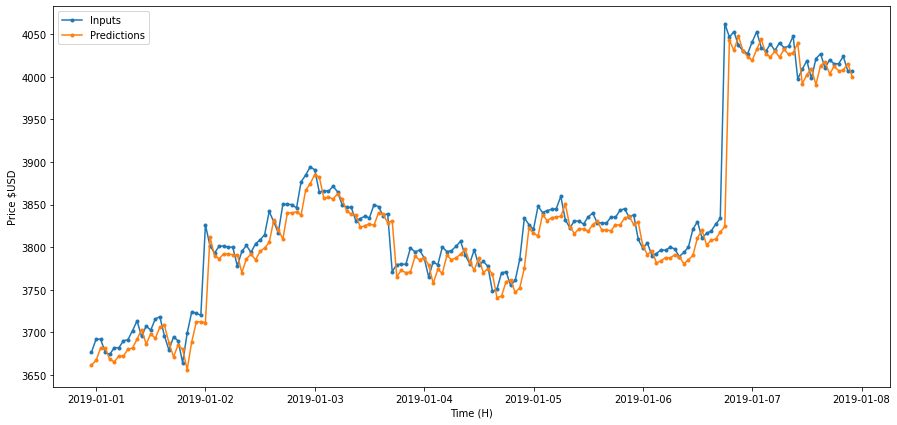

In [42]:
# Plot a sample section of the data set
plt.figure(figsize=(15, 7))
days = 7
hours = days * 24
plt.plot(test_df_datetime.index[-hours:], test_df[-hours:], label='Inputs', marker='.')
plt.plot(test_df_datetime.index[-hours:], df_preds_test[-hours - 1:-1], label='Predictions', marker='.')
plt.xlabel('Time (H)')
plt.ylabel('Price $USD')
plt.legend()
plt.plot()

## Conclusion

After all of this code we see and approach of using Recurrent Neural Networks and specifically the Long Short-Term Memory architecture trying to forecast the Bitcoin Prices and we know now this is not a simple task. And even when the last plot shows us interesting results, if you stay and watch it for a little more time, you can realize a pattern in there, you can see the predictions behave almost equal as the inputs does, with the difference they seem to be shifted one period to the right, and for me this is quite disappointing.

There could be several reasons for this to happened, but one that satisfies my enough is this one: **"Running the data on a single point-by-point prediction as mentioned above gives something that matches the returns pretty closely. But this is slightly deceptive. Upon a closer examination, the prediction line is made up of singular prediction points that have had the whole prior true history window behind them. Because of that, the network doesn't need to know much about the time series itself other than that each next point most likely won't be too far from the last point"** you can find the original article [here](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks).

This is just one of the many applications of RNNs, so I hope to keep looking after new opportunities to apply this technology. Thanks.